# Recurrent Neural Networks
---
# Predicting Stock Prices through an LSTM model

In [1]:
''' Linear Algebra '''
import pandas as pd
import numpy as np

'''Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [2]:
''' Handling timestamps'''
import datetime
from datetime import datetime

In [3]:
url = 'https://raw.githubusercontent.com/timjab92/cryptotradingindicator/master/data/BTCUSD_4hours.csv'

data = pd.read_csv(url)
# Dataset is now stored in a Pandas Dataframe
data = data.drop(columns="Unnamed: 0").set_index("date")

In [4]:
data = data[:]
data

,open,high,low,close,volume,log_open,log_high,log_low,log_close
date,,,,,,,,,
2011-12-31 08:00:00,4.390000,4.390000,4.390000,4.390000,0.455581,1.479329,1.479329,1.479329,1.479329
2011-12-31 16:00:00,4.490000,4.513333,4.490000,4.513333,31.620766,1.501702,1.506847,1.501702,1.506847
2012-01-01 04:00:00,4.580000,4.580000,4.580000,4.580000,1.502000,1.521699,1.521699,1.521699,1.521699
2012-01-01 16:00:00,4.840000,4.840000,4.840000,4.840000,10.000000,1.576915,1.576915,1.576915,1.576915
2012-01-01 20:00:00,5.000000,5.000000,5.000000,5.000000,10.100000,1.609438,1.609438,1.609438,1.609438
...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660


In [5]:
CLOSE = 'log_close'

In [6]:
import requests
def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api


def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data[CLOSE])
    add_vol_roc(data)
    data['4h Return'] = data[CLOSE].pct_change()
    data['4h Gradient'] = data[CLOSE].diff()
    data['boll_width'] = data['bollinger_up'] - data['bollinger_down']
    data['stoch_rsi'] = (data['K'] + data['D']) / 2
    return data

## add other features

def add_ema(data, tspan=[12,26,21,50,34,55,99,200]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data[CLOSE].ewm(span=t).mean()
        data[f'dist_ema{t}'] = data[CLOSE] - data[f'ema{t}']
    return data


def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi


def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  


def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data[CLOSE], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data


def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down


def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    for i in ['bollinger_up', 'bollinger_down']:
        data[f'dist_{i}'] = data[CLOSE] - data[i]
    return data


def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data


In [7]:
def get_train_data():
    """
    Returns the raw training dataset for the price of bitcoin since 31.12.2011.
    The index is set to the date.
    """
    data = pd.read_csv("../data/BTCUSD_4hours.csv")
    data['date'] = pd.to_datetime(data.date)
    data_train = data.drop(columns="Unnamed: 0").set_index("date")
    return data_train


def minmaxscaling(data_train):
    """
    applies the minmaxscaler to the training set. Attention! Output needs to be
    defined for data_train_scaled, min1 and range1!!
    """
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    minmax_scaler.fit(data_train)
    data_train_scaled = minmax_scaler.transform(data_train)
    #    min1 = minmax_scaler.data_min_  # [5:9] for log_prices
    #    range1 = minmax_scaler.data_range_  #[5:9]
    return data_train_scaled, minmax_scaler


def get_xgecko(length=60, horizon=1):
    """
    Calls the coingecko API and returns the data used for prediction.
    x_gecko.shape == (no_sequ , length, no_features)
    """
    x_gecko = feature_engineer(get_coingecko())[[CLOSE]][-length:]
    #get scaler the long way
    data_train = feature_engineer(get_train_data())[[CLOSE]]
    data_train_scaled, scaler = minmaxscaling(data_train)

    x_gecko_scaled = scaler.transform(x_gecko)
    x_gecko = np.array(x_gecko_scaled)
    x_gecko = np.reshape(x_gecko, (horizon, length, 1))
    return x_gecko

### Daily return

$ return = \frac{new - old}{old} $

In [8]:
data = feature_engineer(data)

In [9]:
data = data.dropna()

In [10]:
data.head()

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return,4h Gradient,boll_width,stoch_rsi
date,,,,,,,,,,,,,,,,,,,,,
2012-01-10 20:00:00,7.140000,7.140000,7.140000,7.140000,4.598039,1.965713,1.965713,1.965713,1.965713,1.889085,...,1.880396,1.986887,1.773904,-0.021174,0.191808,0.656744,0.027078,0.051824,0.212983,19.086799
2012-01-11 08:00:00,7.033333,7.033333,7.033333,7.033333,1.858932,1.949820,1.949820,1.949820,1.949820,1.898467,...,1.890427,1.981574,1.799280,-0.031753,0.150541,-0.595712,-0.008085,-0.015893,0.182294,31.001688
2012-01-11 12:00:00,7.201538,7.205769,7.201538,7.205769,1.895918,1.974294,1.974876,1.974294,1.974876,1.910262,...,1.898878,1.988336,1.809419,-0.013460,0.165457,0.019896,0.012850,0.025056,0.178916,44.416957
2012-01-11 16:00:00,6.950000,6.950000,6.950000,6.950000,2.987143,1.938716,1.938716,1.938716,1.938716,1.914652,...,1.902687,1.992116,1.813258,-0.053400,0.125458,0.575566,-0.018310,-0.036160,0.178858,48.136398
2012-01-11 20:00:00,7.000000,7.000000,7.000000,7.000000,8.315000,1.945910,1.945910,1.945910,1.945910,1.919473,...,1.906934,1.996089,1.817779,-0.050179,0.128131,1.783596,0.003711,0.007194,0.178310,46.760673


## BITCOIN Price

In [11]:
import seaborn as sns

In [12]:
data.head(1)

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return,4h Gradient,boll_width,stoch_rsi
date,,,,,,,,,,,,,,,,,,,,,
2012-01-10 20:00:00,7.14,7.14,7.14,7.14,4.598039,1.965713,1.965713,1.965713,1.965713,1.889085,...,1.880396,1.986887,1.773904,-0.021174,0.191808,0.656744,0.027078,0.051824,0.212983,19.086799


In [13]:
data

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return,4h Gradient,boll_width,stoch_rsi
date,,,,,,,,,,,,,,,,,,,,,
2012-01-10 20:00:00,7.140000,7.140000,7.140000,7.140000,4.598039,1.965713,1.965713,1.965713,1.965713,1.889085,...,1.880396,1.986887,1.773904,-0.021174,0.191808,0.656744,0.027078,0.051824,0.212983,19.086799
2012-01-11 08:00:00,7.033333,7.033333,7.033333,7.033333,1.858932,1.949820,1.949820,1.949820,1.949820,1.898467,...,1.890427,1.981574,1.799280,-0.031753,0.150541,-0.595712,-0.008085,-0.015893,0.182294,31.001688
2012-01-11 12:00:00,7.201538,7.205769,7.201538,7.205769,1.895918,1.974294,1.974876,1.974294,1.974876,1.910262,...,1.898878,1.988336,1.809419,-0.013460,0.165457,0.019896,0.012850,0.025056,0.178916,44.416957
2012-01-11 16:00:00,6.950000,6.950000,6.950000,6.950000,2.987143,1.938716,1.938716,1.938716,1.938716,1.914652,...,1.902687,1.992116,1.813258,-0.053400,0.125458,0.575566,-0.018310,-0.036160,0.178858,48.136398
2012-01-11 20:00:00,7.000000,7.000000,7.000000,7.000000,8.315000,1.945910,1.945910,1.945910,1.945910,1.919473,...,1.906934,1.996089,1.817779,-0.050179,0.128131,1.783596,0.003711,0.007194,0.178310,46.760673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853,10.792529,...,10.777789,10.840219,10.715358,-0.045367,0.079495,2.306553,-0.000818,-0.008838,0.124861,43.223000
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202,10.792325,...,10.782060,10.834660,10.729461,-0.043457,0.061742,-0.727108,-0.000338,-0.003650,0.105199,27.575649
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660,10.792838,...,10.786118,10.828258,10.743977,-0.032598,0.051684,0.307177,0.000413,0.004458,0.084281,12.666568


In [14]:
data.corr()

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return,4h Gradient,boll_width,stoch_rsi
open,1.000000,1.000000,1.000000,1.000000,-0.178667,0.654466,0.654463,0.654469,0.654464,0.654221,...,0.654006,0.654670,0.653057,-0.037776,0.056878,-0.017658,-0.005224,0.002259,0.064538,-0.005177
high,1.000000,1.000000,0.999999,1.000000,-0.178574,0.654465,0.654461,0.654467,0.654462,0.654220,...,0.654006,0.654672,0.653054,-0.037897,0.056920,-0.017653,-0.005236,0.002227,0.064652,-0.005201
low,1.000000,0.999999,1.000000,1.000000,-0.178768,0.654462,0.654458,0.654465,0.654459,0.654215,...,0.654001,0.654662,0.653054,-0.037646,0.056831,-0.017664,-0.005200,0.002318,0.064415,-0.005150
close,1.000000,1.000000,1.000000,1.000000,-0.178668,0.654462,0.654459,0.654465,0.654460,0.654217,...,0.654003,0.654666,0.653053,-0.037770,0.056883,-0.017659,-0.005215,0.002281,0.064538,-0.005173
volume,-0.178667,-0.178574,-0.178768,-0.178668,1.000000,-0.305623,-0.305503,-0.305760,-0.305632,-0.304560,...,-0.304193,-0.299138,-0.309125,-0.204966,0.123268,0.311506,-0.043110,-0.082692,0.227273,-0.002652
log_open,0.654466,0.654465,0.654462,0.654462,-0.305623,1.000000,1.000000,1.000000,1.000000,0.999923,...,0.999807,0.999562,0.999617,-0.032285,0.023159,-0.053429,-0.015769,-0.003169,0.038280,-0.028449
log_high,0.654463,0.654461,0.654458,0.654459,-0.305503,1.000000,1.000000,1.000000,1.000000,0.999923,...,0.999808,0.999567,0.999615,-0.032431,0.023224,-0.053425,-0.015790,-0.003208,0.038427,-0.028465
log_low,0.654469,0.654467,0.654465,0.654465,-0.305760,1.000000,1.000000,1.000000,1.000000,0.999922,...,0.999805,0.999557,0.999619,-0.032113,0.023085,-0.053435,-0.015707,-0.003093,0.038110,-0.028428
log_close,0.654464,0.654462,0.654459,0.654460,-0.305632,1.000000,1.000000,1.000000,1.000000,0.999922,...,0.999807,0.999562,0.999617,-0.032270,0.023161,-0.053432,-0.015731,-0.003137,0.038271,-0.028444
ema12,0.654221,0.654220,0.654215,0.654217,-0.304560,0.999923,0.999923,0.999922,0.999922,1.000000,...,0.999963,0.999729,0.999762,-0.040528,0.015100,-0.053337,-0.020741,-0.009820,0.038789,-0.034892


In [15]:
data.keys()

Index(['open', 'high', 'low', 'close', 'volume', 'log_open', 'log_high',
       'log_low', 'log_close', 'ema12', 'dist_ema12', 'ema26', 'dist_ema26',
       'ema21', 'dist_ema21', 'ema50', 'dist_ema50', 'ema34', 'dist_ema34',
       'ema55', 'dist_ema55', 'ema99', 'dist_ema99', 'ema200', 'dist_ema200',
       'rsi', 'K', 'D', 'sma', 'bollinger_up', 'bollinger_down',
       'dist_bollinger_up', 'dist_bollinger_down', 'vol_roc', '4h Return',
       '4h Gradient', 'boll_width', 'stoch_rsi'],
      dtype='object')

In [16]:
selected_features=[CLOSE,'dist_ema99', 'stoch_rsi', 'boll_width']
#21,99 emas

In [17]:
selected_data = data[selected_features]
selected_data

,log_close,dist_ema99,stoch_rsi,boll_width
date,,,,
2012-01-10 20:00:00,1.965713,0.164531,19.086799,0.212983
2012-01-11 08:00:00,1.949820,0.142529,31.001688,0.182294
2012-01-11 12:00:00,1.974876,0.160839,44.416957,0.178916
2012-01-11 16:00:00,1.938716,0.119760,48.136398,0.178858
2012-01-11 20:00:00,1.945910,0.122041,46.760673,0.178310
...,...,...,...,...
2021-08-22 12:00:00,10.794853,0.075134,43.223000,0.124861
2021-08-22 16:00:00,10.791202,0.070054,27.575649,0.105199
2021-08-22 20:00:00,10.795660,0.073022,12.666568,0.084281


<AxesSubplot:>

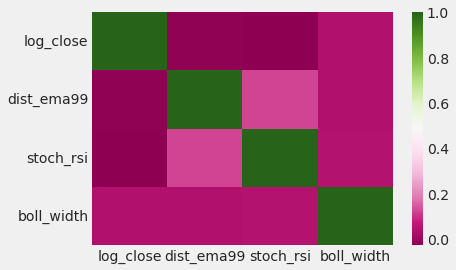

In [18]:
sns.heatmap(selected_data.corr(),cmap="PiYG")

In [19]:
len(selected_data)

20809

In [20]:
np.array(selected_data)[1][0]

1.9498202623235736

In [21]:
selected_data

,log_close,dist_ema99,stoch_rsi,boll_width
date,,,,
2012-01-10 20:00:00,1.965713,0.164531,19.086799,0.212983
2012-01-11 08:00:00,1.949820,0.142529,31.001688,0.182294
2012-01-11 12:00:00,1.974876,0.160839,44.416957,0.178916
2012-01-11 16:00:00,1.938716,0.119760,48.136398,0.178858
2012-01-11 20:00:00,1.945910,0.122041,46.760673,0.178310
...,...,...,...,...
2021-08-22 12:00:00,10.794853,0.075134,43.223000,0.124861
2021-08-22 16:00:00,10.791202,0.070054,27.575649,0.105199
2021-08-22 20:00:00,10.795660,0.073022,12.666568,0.084281


### Temporal Train-Test Split

In [22]:
train_percentage = 95

In [23]:
train_len = int(len(selected_data) * train_percentage/100)
train_len

19768

In [24]:
data_train = selected_data[:train_len]
data_test = selected_data[train_len:]


## LSTM

In [25]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler(feature_range = (0,1))

minmax_scaler.fit(data_train)

data_train_scaled = minmax_scaler.transform(data_train)
data_test_scaled = minmax_scaler.transform(data_test)

In [26]:
minmax_scaler.data_max_

array([ 10.96497341,   0.70830725, 100.        ,   2.05121311])

In [27]:
minmax_scaler.data_min_

array([ 1.44133982, -0.67034595,  0.        ,  0.00341926])

In [28]:
min1 = minmax_scaler.data_min_[0]
min1

1.4413398207497814

In [29]:
range1 = minmax_scaler.data_range_[0]
range1

9.523633584330872

In [30]:
data_train_scaled[:]

array([[0.05506018, 0.60557433, 0.19086799, 0.10233611],
       [0.05339143, 0.58961538, 0.31001688, 0.08734989],
       [0.05602234, 0.6028965 , 0.44416957, 0.08570052],
       ...,
       [0.98240346, 0.49974844, 0.94129317, 0.06864497],
       [0.98260965, 0.50087396, 0.90975756, 0.07100402],
       [0.98073397, 0.48788324, 0.864088  , 0.07188591]])

### Creating subsequences...

In [31]:
window_size = 120  # test with small window size
horizon = 6 #number of predictions into the future :) 
data_train_subsequences = []
fake_y_train = []
for k in range(len(data_train_scaled)-(window_size-1)-horizon):
    data_train_subsequences.append(data_train_scaled[k:k+window_size])
    fake_y_train.append(data_train_scaled[k+window_size:k+window_size+horizon]) #add [0] for log_price to be predicted

In [32]:
np.array(fake_y_train).shape

(19643, 6, 4)

In [33]:
X_train = np.array(data_train_subsequences)
y_train = np.array(fake_y_train)[:,:,0] #.reshape(-1,1)

In [34]:
X_train.shape

(19643, 120, 4)

In [35]:
y_train.shape

(19643, 6)

In [36]:
#with the same window_size & horizon as the train data
data_test_subsequences = []
fake_y_test = []
for k in range(len(data_test_scaled)-(window_size-1)-horizon):
    data_test_subsequences.append(data_test_scaled[k:k+window_size])
    fake_y_test.append(data_test_scaled[k+window_size:k+window_size+horizon])

In [37]:
X_test = np.array(data_test_subsequences)
y_test = np.array(fake_y_test)[:,:,0] #.reshape(-1,1)

In [38]:
X_test.shape

(916, 120, 4)

In [39]:
y_test.shape

(916, 6)

### LSTM

#### RNN Architecture

In [40]:
pd.DataFrame(y_test).shape

(916, 6)

In [41]:
from tensorflow.keras import metrics

my_mae = metrics.MeanAbsoluteError(
    name='mean_absolute_error', dtype=None
)


2021-08-31 08:56:52.253342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-31 08:56:52.253399: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-31 08:56:55.203564: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-31 08:56:55.203606: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-31 08:56:55.203631: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-33CGF2OU): /proc/driver/nvidia/version does not exist
2021-08-31 08:56:55.203814: I tensorflow/core/platform/cpu_fe

In [42]:
from tensorflow.keras import Sequential, layers

# Build the LSTM model
model = Sequential()

model.add(layers.LSTM(units=128,
                     return_sequences = True,
                     activation = "tanh"
                    #activation = "relu"
                     #input_shape = X_train[0].shape)
                     ))

model.add(layers.LSTM(units=64,
                      return_sequences = False,
                      activation = "relu"  
                    #activation = "relu"
                     ))

# model.add(layers.Dense(25,
#                          activation="relu"))
model.add(layers.Dense(32,
                        activation = "tanh" 
                       #activation="relu"
                      ))
#model.add(layers.Dense(16,activation="relu"))
model.add(layers.Dense(8,
                       activation = "relu"
                       #activation="relu"
                      ))
model.add(layers.Dense(6,
                      activation = "relu" 
                      #activation="relu"
                      ))

#model.summary()



In [43]:
model.compile(loss="mse",
             optimizer = "adam",#rmsprop
             metrics = "mae"#[my_mae]
             )

#### Training

In [44]:
#### perhaps create a validation and train sets by hand

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping 

es = EarlyStopping(patience = 5, 
                   restore_best_weights= True,
                   monitor = "mae"
                  )

history = model.fit(X_train, y_train,
          validation_split = 0.2,
         batch_size=16,
         epochs=50,
         verbose = 1,
         callbacks = [es]
                   )

2021-08-31 08:56:55.419495: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
983/983 [==============================] - 172s 172ms/step - loss: 0.0905 - mae: 0.1615 - val_loss: 0.0311 - val_mae: 0.1479
Epoch 2/50
983/983 [==============================] - 168s 171ms/step - loss: 2.8678e-04 - mae: 0.0093 - val_loss: 1.2156e-04 - val_mae: 0.0088
Epoch 3/50
983/983 [==============================] - 158s 161ms/step - loss: 4.8135e-05 - mae: 0.0049 - val_loss: 2.9810e-05 - val_mae: 0.0037
Epoch 4/50
983/983 [==============================] - 162s 165ms/step - loss: 5.2071e-05 - mae: 0.0053 - val_loss: 2.8981e-05 - val_mae: 0.0038
Epoch 5/50
983/983 [==============================] - 164s 167ms/step - loss: 4.6230e-05 - mae: 0.0049 - val_loss: 1.8962e-05 - val_mae: 0.0031
Epoch 6/50
983/983 [==============================] - 158s 161ms/step - loss: 4.3865e-05 - mae: 0.0049 - val_loss: 4.6625e-05 - val_mae: 0.0052
Epoch 7/50
983/983 [==============================] - 161s 164ms/step - loss: 4.6834e-05 - mae: 0.0049 - val_loss: 4.6752e-04 - val_mae: 0.0212


In [ ]:
100*17 / 60

In [ ]:
def plot_loss_mae(history):
    
    fig, ax =plt.subplots(1,2,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
#     # --- MAE

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('Model MAE', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)   
    
    plt.show()
    

In [ ]:
plot_loss_mae(history)

#### Evaluating

In [ ]:
res = model.evaluate(X_test, np.array(y_test), verbose = 1)
res


#### Predictions

In [ ]:
predictions = model.predict(X_test)


In [ ]:
len(predictions), len(y_test)

In [ ]:
predictions[0:3]

In [ ]:
y_test_unscaled = y_test * range1 + min1

In [ ]:
predictions_unscaled = predictions * range1 + min1

In [ ]:
predictions_unscaled[0:3]

The operation computed during a `MinMaxScaler` Operation is:

$$x_{scaled} = \frac{x - x_{min}}{x_{max}- x_{min}}$$

To descale it:

$$x = x_{scaled} * (x_{max}- x_{min}) + x_{min}$$

Or use the `inverse_transform` directly provided...

In [ ]:
X_test.shape

In [ ]:
predictions.shape

In [ ]:
pred = pd.DataFrame(predictions_unscaled, columns = ['pred_1','pred_2','pred_3','pred_4','pred_5','pred_6'])
test = pd.DataFrame(y_test_unscaled, columns = ['test_1','test_2','test_3', 'test_4','test_5','test_6'])
result = pd.concat([pred, test], axis=1)

In [ ]:
result

In [ ]:
weight = np.mean(result['test_1'] - result['pred_1'])

In [ ]:
result['pred_weight'] = result['pred_1'] + weight

In [ ]:
# for col in ['pred_1','pred_2','pred_3','test_1','test_2','test_3']

In [ ]:
# mae_1 = np.mean(np.abs(result['test_1'] - result['pred_1']))
# mae_2 = np.mean(np.abs(result['test_2'] - result['pred_2']))
# mae_3 = np.mean(np.abs(result['test_3'] - result['pred_3']))

In [ ]:
#log_data
mae_1 = np.mean(np.abs(np.exp(result['test_1']) - np.exp(result['pred_1'])))
mae_2 = np.mean(np.abs(np.exp(result['test_2']) - np.exp(result['pred_2'])))
mae_3 = np.mean(np.abs(np.exp(result['test_3']) - np.exp(result['pred_3'])))
#log_data
mae_4 = np.mean(np.abs(np.exp(result['test_4']) - np.exp(result['pred_4'])))
mae_5 = np.mean(np.abs(np.exp(result['test_5']) - np.exp(result['pred_5'])))
mae_6 = np.mean(np.abs(np.exp(result['test_6']) - np.exp(result['pred_6'])))

In [ ]:
print(mae_1)
print(mae_2)
print(mae_3)
print(mae_4)
print(mae_5)
print(mae_6)

In [ ]:
np.mean([mae_1,mae_2,mae_3,mae_4,mae_5,mae_6])

In [ ]:
mae = np.mean(np.abs(y_test_unscaled[:,0] - predictions_unscaled[:,0]))
mae

In [ ]:
# df =pd.DataFrame()
# df['y_test'] = pd.DataFrame(y_test_unscaled).apply(lambda x: np.exp(x))
# df['pred'] = pd.DataFrame(predictions_unscaled).apply(lambda x: np.exp(x))
# df['diff'] = df['y_test'] - df['pred']

In [ ]:
# np.mean(np.abs(df['diff']))

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(result[['test_1', 'pred_1']][-30:], label=["test", "pred"])
plt.legend()
plt.show()


# PREDICTION WITH COINGECKO!!!

In [ ]:
import requests

def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api

In [ ]:
gecko_api = get_coingecko()

In [ ]:
coingecko = feature_engineer(gecko_api)[selected_features][-160:]

In [ ]:
x_gecko_scaled = minmax_scaler.transform(coingecko)

In [ ]:
#window_size=18

In [ ]:
# x_gecko_subsequences = []
# for k in range(len(x_gecko_scaled)-(window_size-1)-horizon):
#     x_gecko_subsequences.append(x_gecko_scaled[k:k+window_size])

In [ ]:
# x_gecko = np.array(x_gecko_subsequences)

In [ ]:
x_gecko_scaled.shape

In [ ]:
x_gecko = x_gecko_scaled[-window_size:]

In [ ]:
x_gecko.shape

In [ ]:
x_gecko = np.array(x_gecko).reshape(-1,window_size,len(selected_features))

In [ ]:
x_gecko.shape

In [ ]:
pred_gecko = model.predict(x_gecko)

In [ ]:
pred_gecko_unscaled = pred_gecko * range1 + min1

In [ ]:
pred_gecko_unscaled

In [ ]:
pred_weighted

In [ ]:
coingecko

In [ ]:
np.exp(pred_gecko_unscaled)

In [ ]:
##########

In [ ]:
pred_weighted = pred_gecko_unscaled + weight

In [ ]:
df = coingecko[[CLOSE]].reset_index(drop=True).apply(lambda x: np.exp(x))

In [ ]:
df1 = pd.DataFrame(pred_weighted.reshape(6,1),columns=[CLOSE]).apply(lambda x: np.exp(x))

In [ ]:
df2 = pd.concat([df,df1],axis=0).reset_index(drop=True)
df2

In [ ]:
plt.plot(df2[130:160])
plt.plot(df2[160:])


In [ ]:
x_gecko_scaled
x_gecko_subsequences = []
for k in range(len(x_gecko_scaled)-(window_size-1)-horizon):
    x_gecko_subsequences.append(x_gecko_scaled[k:k+window_size])

In [ ]:
#x_gecko = np.array(x_gecko)
x_gecko = np.reshape(x_gecko, (-1,window_size,len(selected_features))) #[-horizon:,:,:]

x_gecko.shape

In [ ]:
predictions = model.predict(x_gecko)

predictions

In [ ]:
predictions_unscaled = predictions * range1 + min1

In [ ]:
#np.exp(predictions_unscaled)

In [ ]:
from datetime import datetime
dateTimeObj = datetime.now()
print(dateTimeObj)

In [ ]:
close = pd.DataFrame(coingecko.close[-10:].reset_index().drop(columns='index'))

In [ ]:
close

In [ ]:
for i in range(len(close),len(close) + horizon):
    print(i)

In [ ]:
pred = pd.DataFrame(np.exp(predictions_unscaled), columns = ['close']).set_index(pd.Index(range(len(close),len(close) + horizon)))

In [ ]:
df = pd.DataFrame(np.exp(predictions_unscaled), columns = ['pred'])
df['gecko'] = coingecko['log_close']
df

In [ ]:
plt.plot(close)
plt.plot(pred)

In [ ]:
plt.plot(coingecko['close'][-20:])
plt.plot(predictions_unscaled)